In [18]:
from jax_circuits import*
from topology import *
from penalty import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

# Aux

In [157]:
def random_cp_angles(num_angles, cp_mask, **kwargs):
    return random_angles(num_angles, **kwargs)*(1-cp_mask)

def cp_loss(loss_func, angles, cp_mask, reg=1, h=2, t=1e-3):
    cp_angles = angles*anz.cp_mask
    penalty_loss = cp_penalty_linear(cp_angles, h, t).sum()
    return loss_func(angles)+reg*penalty_loss

def cnot_value(a, threshold=1e-2):
    t=threshold
    a = a % (2*jnp.pi)
    return jnp.piecewise(a, 
                         [a < t, jnp.abs(a-jnp.pi)<t],
                         [0, 1, 2])    
def count_cnots(angles, **kwargs):
    return sum([cnot_value(a, **kwargs) for a in angles])

def plot_cp_angles(angles, h=2, t=1e-2):
    a_sweep = jnp.linspace(0, 2*jnp.pi, 200)
    angles = angles % (2*jnp.pi)
    plt.plot(a_sweep, cp_penalty_linear(a_sweep, h, t))
    plt.scatter(angles, 
                cp_penalty_linear(angles, h, t)+0.1*random.normal(random.PRNGKey(0), (len(angles), )), 
                alpha=0.5)
    

# Random unitary 2

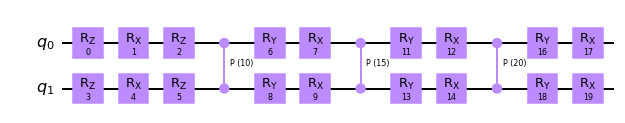

In [19]:
num_qubits = 2
anz = Ansatz(2, 'cp', placements=fill_layers(sequ_layer(num_qubits), 3))
angles = jnp.arange(anz.num_angles, dtype='float32')
u_target = unitary_group.rvs(2**num_qubits, random_state=14)
anz.circuit(angles).draw(output='mpl')

In [22]:
%%time
angles_history_adam, loss_history_adam = anz.learn(u_target, method='adam')

CPU times: user 2.85 s, sys: 4.39 ms, total: 2.85 s
Wall time: 2.84 s


In [24]:
%%time
angles_history_ngd, loss_history_ngd = anz.learn(u_target, method='natural_gd')

CPU times: user 5.32 s, sys: 84.3 ms, total: 5.41 s
Wall time: 5.29 s


In [32]:
%%time
angles_history_nadam, loss_history_nadam = anz.learn(u_target, method='natural_adam')

CPU times: user 5.64 s, sys: 388 ms, total: 6.03 s
Wall time: 5.42 s


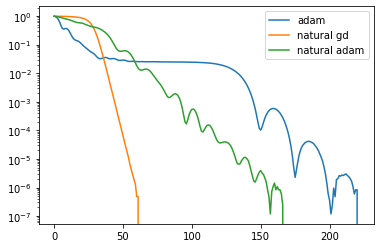

In [33]:
plt.plot(loss_history_adam, label='adam')
plt.plot(loss_history_ngd, label='natural gd')
plt.plot(loss_history_nadam, label='natural adam')
plt.legend()
plt.yscale('log')

# 2-qubit systematically

Let us start small. The first goal is to reliably identify 0, 1, 2, or 3 CNOT unitaries.

In [149]:
num_qubits = 2
u_sample = []
for d in range(4):
    anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), d))
    angles = random_angles(anz.num_angles, key=random.PRNGKey(d))
    u_sample.append(anz.unitary(angles))

Here is an ansatz that we going to teach this.

In [158]:
num_qubits = 2
depth = 3
anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), depth))
anz.circuit().draw(output='mpl')

anz_cost = [lambda angs: disc2(anz.unitary(angs), u_sample[i]) for i in range(4)]

Now we try different methods.

## N=3

In [161]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
angles_history_gd, loss_hisotory_gd = gradient_descent_minimize(cp_cost_func,
                                                                anz.num_angles)

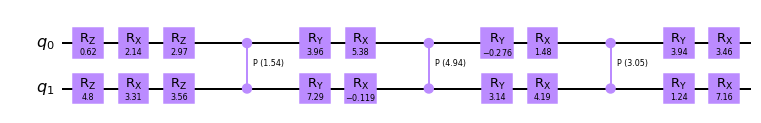

In [163]:
anz.circuit(angles_history_gd[-1]).draw(output='mpl')

In [164]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
angles_history_adam, loss_hisotory_adam = optax_minimize(cp_cost_func,
                                                         anz.num_angles, 
                                                         optax.adam(0.1))

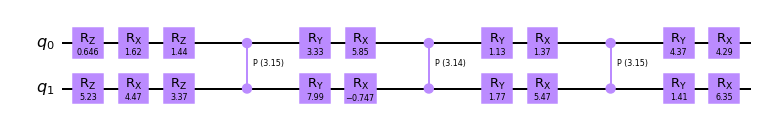

In [165]:
anz.circuit(angles_history_adam[-1]).draw(output='mpl')

In [184]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
preconditioner = plain_natural_preconditioner(anz.unitary)
angles_history_ngd, loss_hisotory_ngd = gradient_descent_minimize(cp_cost_func,
                                                                  anz.num_angles, 
                                                                  preconditioner_func=preconditioner,
                                                                  learning_rate=0.1)

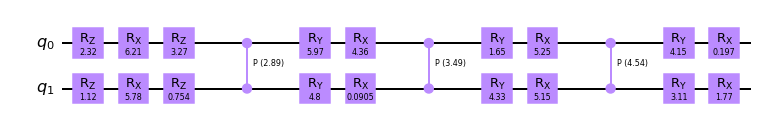

In [187]:
anz.circuit(angles_history_ngd[-1] % (2*jnp.pi)).draw(output='mpl')

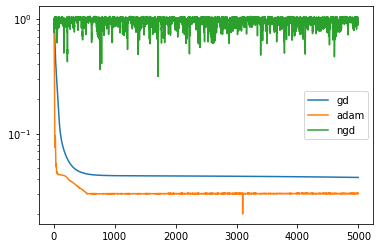

In [186]:
plt.plot(loss_hisotory_gd, label='gd')
plt.plot(loss_hisotory_adam, label='adam')
plt.plot(loss_hisotory_ngd, label='ngd')
plt.yscale('log')
plt.legend()